In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import matplotlib.gridspec as gridspec # to do the grid of plots

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import gc

In [2]:
# Output a summary table of a given dataframe. Get this good idea from other briliant kernels.
def summary(df):

    # give out the dimensional infomation of the data-frame
    print(f"Dimensionality of the DataFrame: {df.shape}") 

    # create a table based on data-type of each column of the input data-frame.
    table = pd.DataFrame(df.dtypes,columns=['dtypes'])

    # Reset the index of the DataFrame, and use the default index (column name) instead. Change the column name 'index' to 'name' and drop the index column.
    table = table.reset_index() 
    table['Name'] = table['index']
    table = table[['Name','dtypes']]

    # Add new column for the summary table.
    table['Missing'] = df.isnull().sum().values # check if any column in the input df has missing column.
    table['Uniques'] = df.nunique().values      # number of unique value in the column
    table['First Value'] = df.loc[0].values     # 1st value of the column
    table['Second Value'] = df.loc[1].values    # 2nd value of the column
    table['Third Value'] = df.loc[2].values     # 3rd value of the column

    # Study the randomness of each column, use scipy.stats.entropy, calculated by S = -sum(pk * log(pk), axis=axis)
    for name in table['Name'].value_counts().index:
        table.loc[table['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return table


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv', index_col='id')

In [4]:
table = summary(df_train)
table

Dimensionality of the DataFrame: (300000, 25)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,id,int64,0,300000,0,1,2,18.19
1,bin_0,int64,0,2,0,0,0,0.55
2,bin_1,int64,0,2,0,1,0,0.82
3,bin_2,int64,0,2,0,0,0,0.96
4,bin_3,object,0,2,T,T,F,1.00
5,bin_4,object,0,2,Y,Y,Y,0.94
6,nom_0,object,0,3,Green,Green,Blue,1.55
7,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid,2.45
8,nom_2,object,0,6,Snake,Hamster,Lion,2.44
9,nom_3,object,0,6,Finland,Russia,Russia,2.45


From the summary:

1. None of the column from the training set has missing data.
2. bin_3 & bin_4 are binary data but not in 0 and 1 format. Need map the "Y","N","T","F" to 0, 1 later.
3. barely can tell the relationship between different column. seems no relation between each other.
4. ord_0 is a number feature with small unique value.
5. ord_0 - ord_4 have very less unique value, can be ordinal encoding.
6. ord_5 needs a better look again.


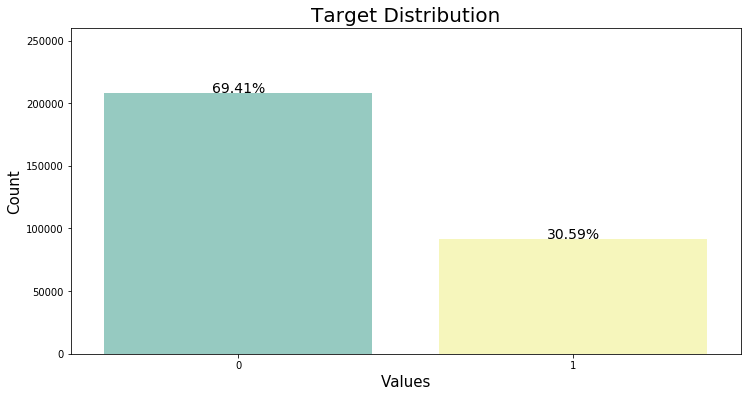

In [5]:
total = len(df_train)
plt.figure(figsize=(12,6))

g = sns.countplot(x='target', data=df_train, palette="Set3" ) #Show the counts of observations in each categorical bin using bars.

# set chart name, x axix name, y axix name
g.set_title("Target Distribution", fontsize = 20)
g.set_xlabel("Values", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)

# show counts percentage
sizes=[] # highest values in y, for calculate percentage
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.25) # set y limit based on highest heights

plt.show()

From chart we learned that the target is a binary feature 0 or 1.

0 as 69.41%
1 as 30.59%

In [6]:
# Study of the binary column
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

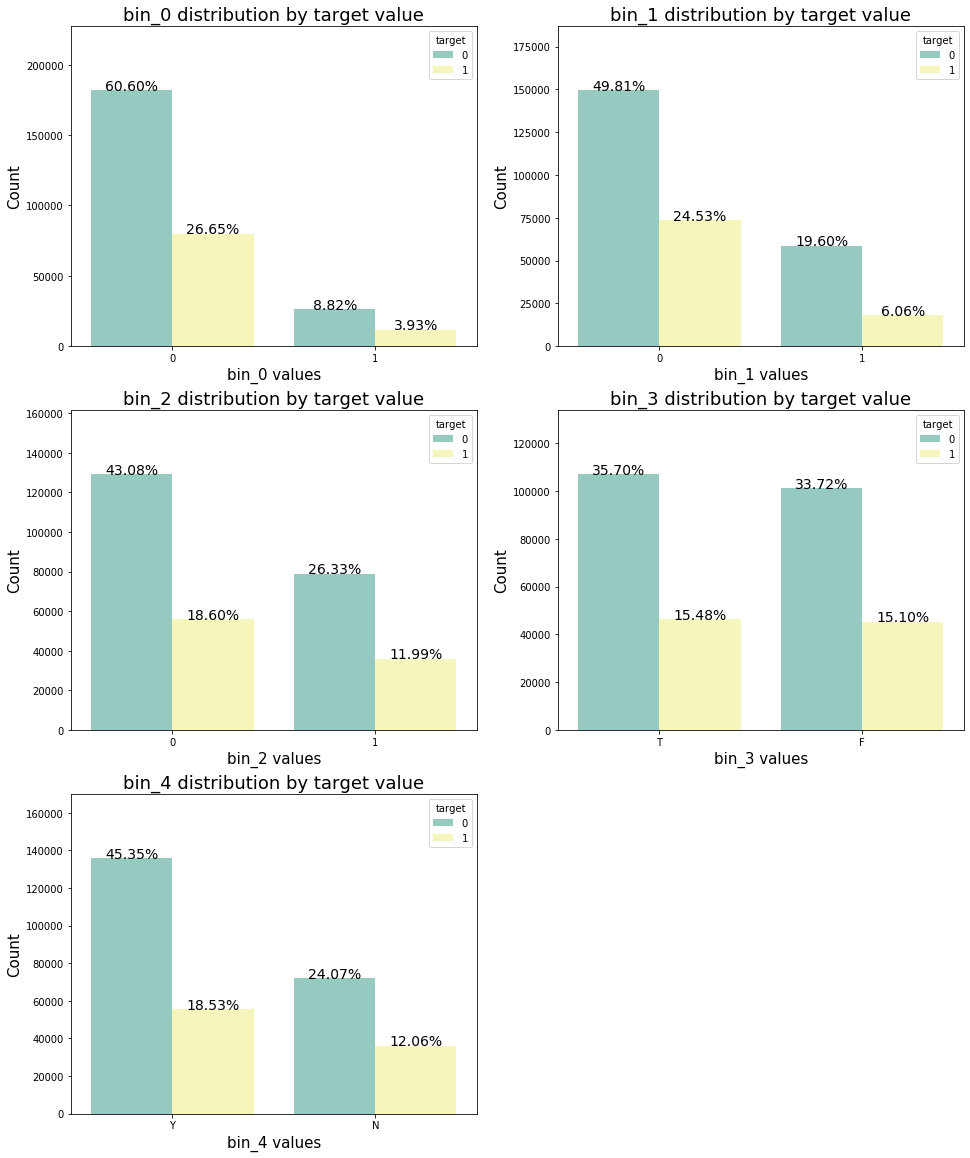

In [7]:
#Looking the V's features
grid = gridspec.GridSpec(3, 2) # The grid of chart
plt.figure(figsize=(16,20)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(df_train[bin_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=df_train, hue='target', palette='Set3') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} distribution by target value', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    ax.set_ylim(0, max(sizes) * 1.25) # set y limit based on highest heights
    
    
    
plt.show()

1. All the binary features have larger count for target value = 0, this is explained the 69.41% of target value = 0.

2. Except bin_3, bin_4, all the other binary feature have similar value distribution. (value 0 have larger percentage than value 1, assume T,Y stands for 1, F, N stands for 0)

3. bin_3 has similar percentage for value 0 and value 1.

4. bin_4 has large percentage value 1 than value 0.



In [8]:
# study for Nominal Features.

# we seperate Nominal Features to 2 group by the number of unique value.
# group1 (nom_1 - nom_4) and group2 (nom_5 - nom_9)
nom_group1 = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
nom_group2 = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

In [9]:
summary(df_train[nom_group1+nom_group2])

Dimensionality of the DataFrame: (300000, 10)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,nom_0,object,0,3,Green,Green,Blue,1.55
1,nom_1,object,0,6,Triangle,Trapezoid,Trapezoid,2.45
2,nom_2,object,0,6,Snake,Hamster,Lion,2.44
3,nom_3,object,0,6,Finland,Russia,Russia,2.45
4,nom_4,object,0,4,Bassoon,Piano,Theremin,1.97
5,nom_5,object,0,222,50f116bcf,b3b4d25d0,3263bdce5,7.49
6,nom_6,object,0,522,3ac1b8814,fbcb50fc1,0922e3cb8,8.74
7,nom_7,object,0,1220,68f6ad3e9,3b6dd5612,a6a36f527,9.97
8,nom_8,object,0,2215,c389000ab,4cd920251,de9c9f684,10.84
9,nom_9,object,0,11981,2f4cb3d51,f83c56c21,ae6800dd0,13.27


From the data frame summary, we can find that nom_group2(5-9) have a very large number of unique values. With the extreme high entropy value, we could predict the target value to it is pretty random too.

In [10]:
# This function plot graphs for it's value distribution and the target value true percentage.
def plot_cat_dist(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(df_train[cols]): 
        # Compute a simple cross tabulation of nominal feature unique value and target value.
        tmp = pd.crosstab(df_train[col], df_train['target'], normalize='index') * 100
        tmp = tmp.reset_index()

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df_train, order=list(tmp[col].values) , color='aquamarine') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build the target(true).
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y=1, data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp[1].min()-5,tmp[1].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

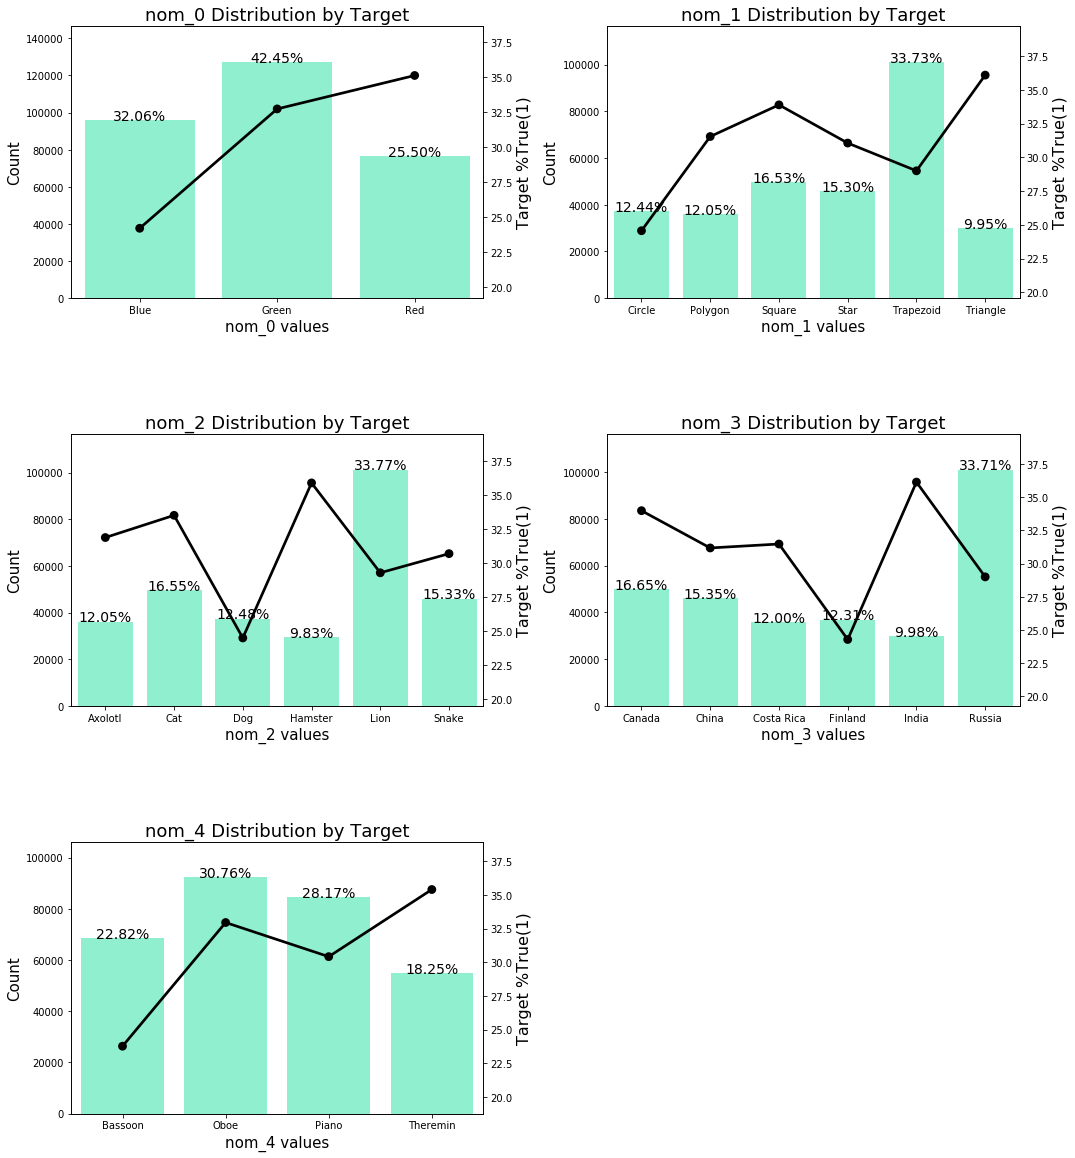

In [11]:
# Group1 study
plot_cat_dist(df_train, nom_group1, vis_row=5, vis_col=2)

Finding:

1. the lowest percentage of unique value in each nominal feature of group 1, has highest target true value.

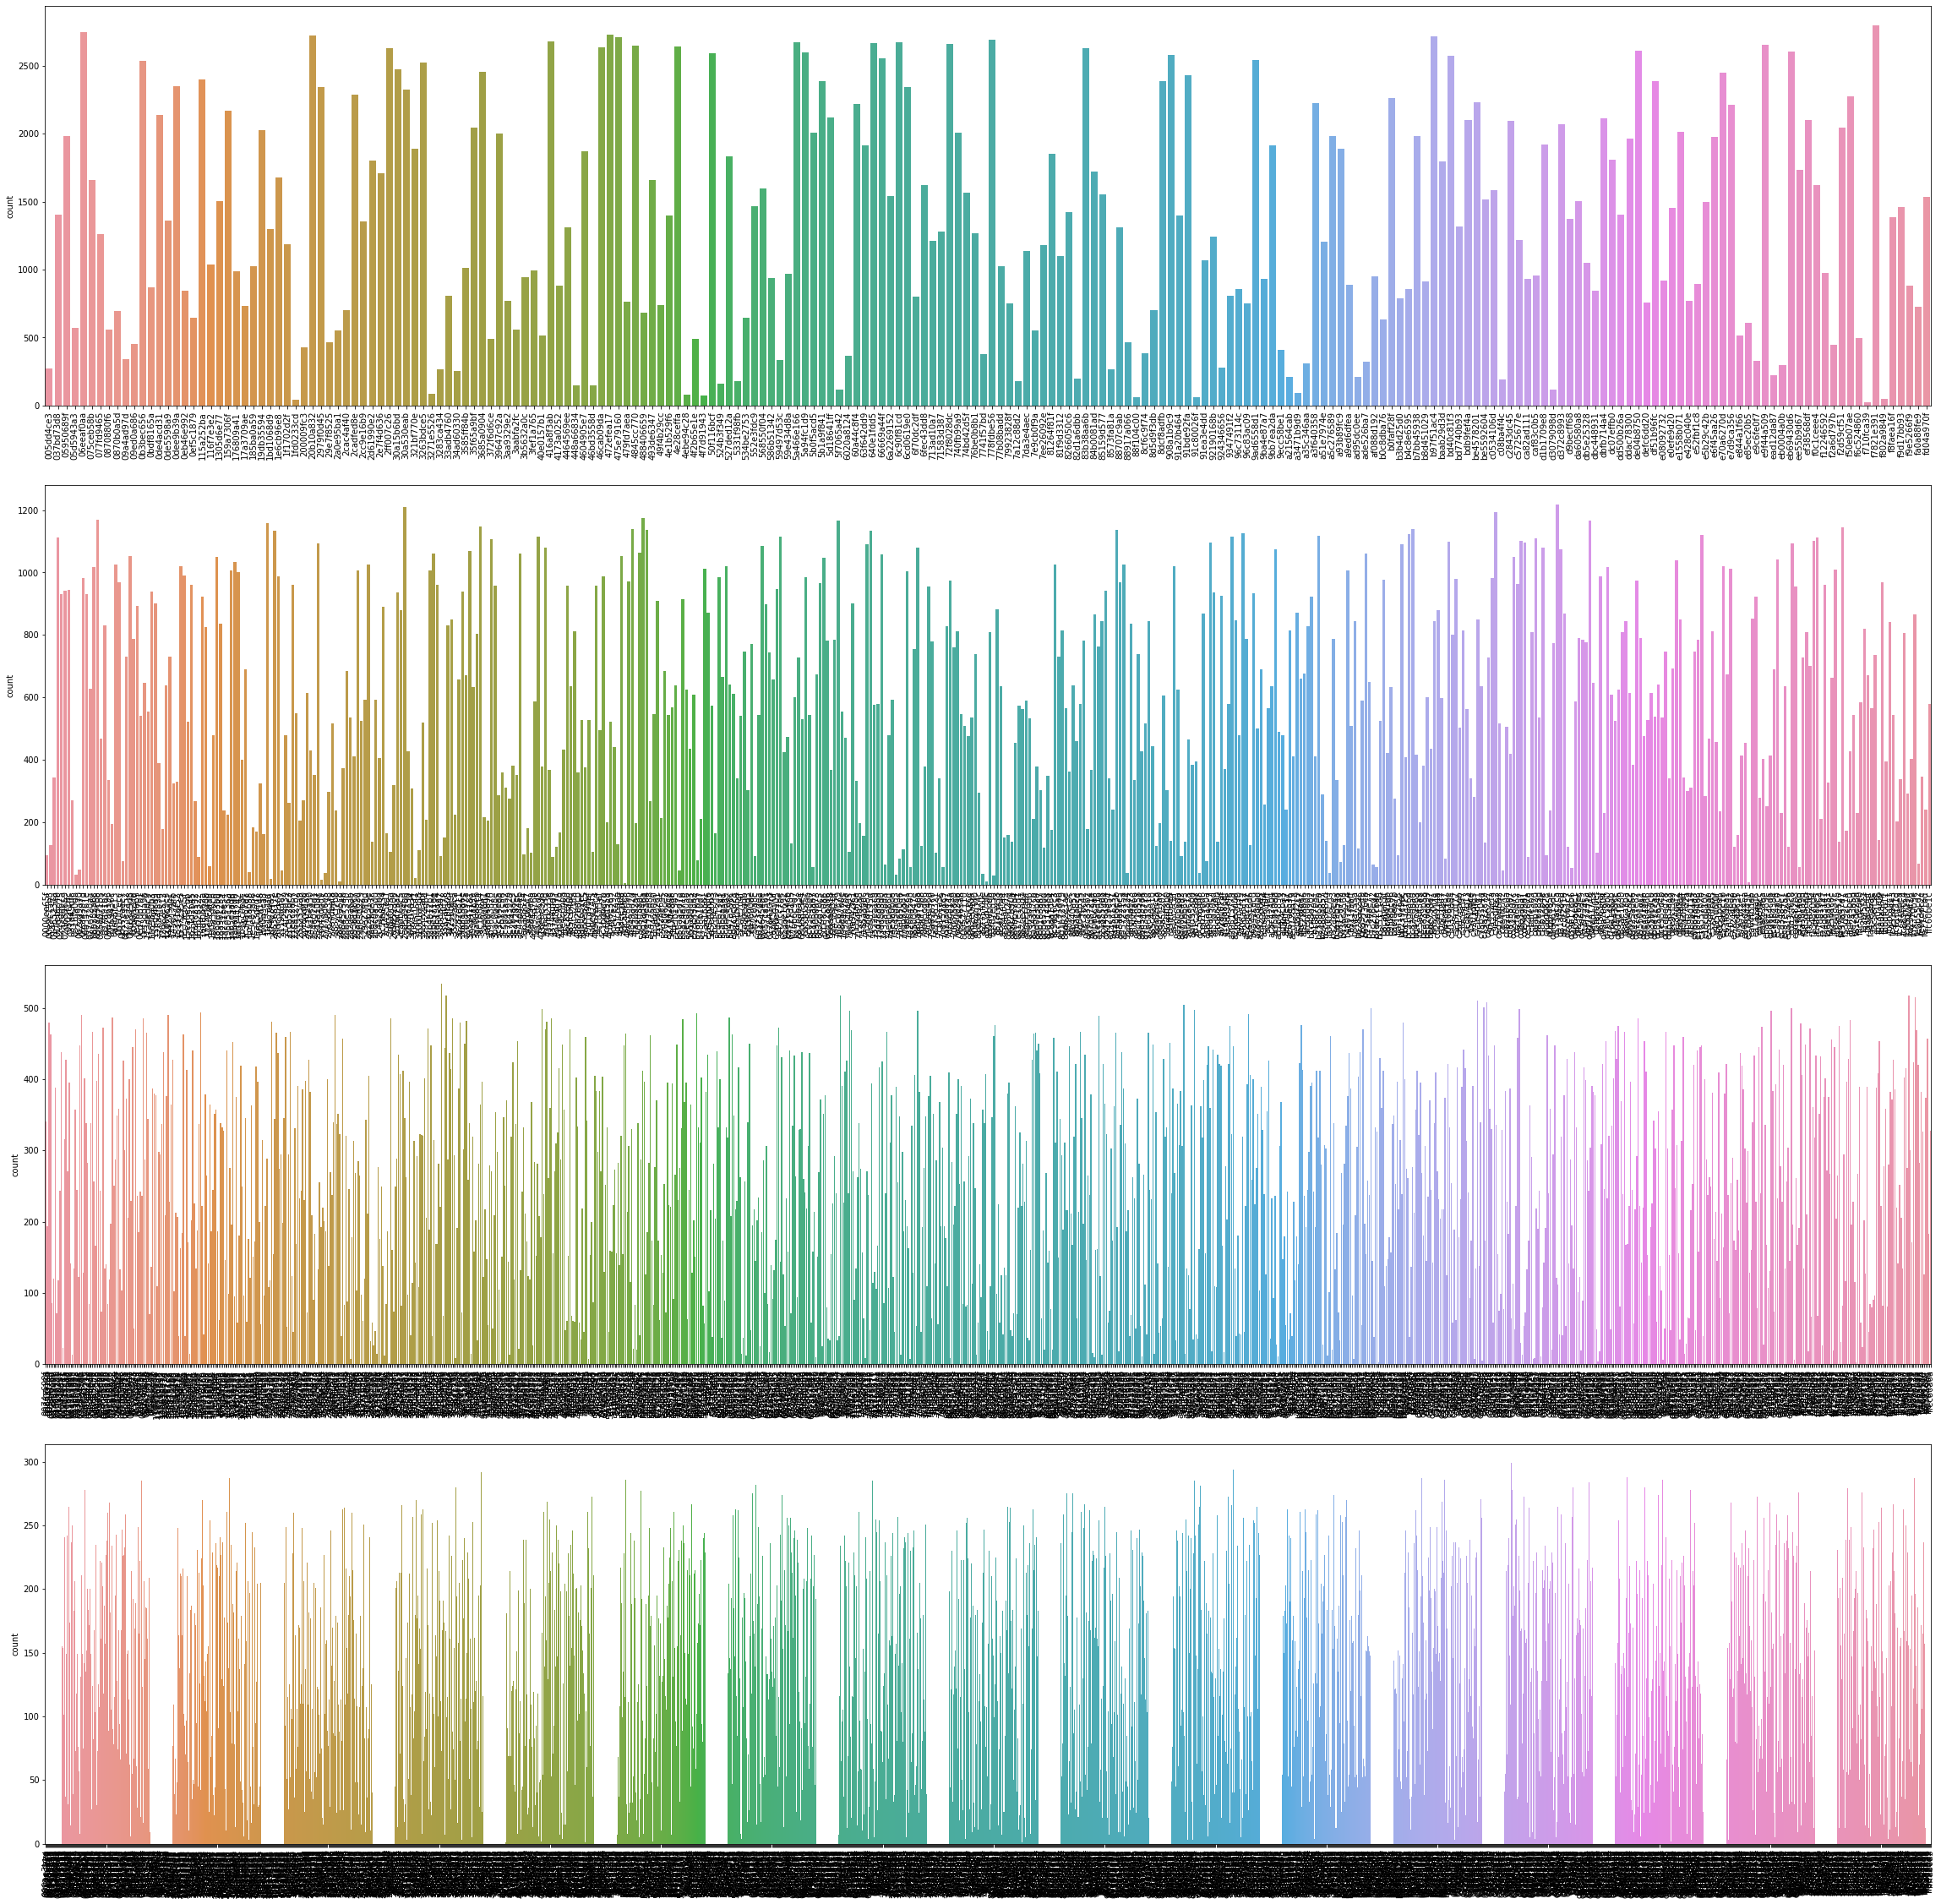

In [12]:
# distribution graph of nom group2
fig, ax = plt.subplots(4,1,figsize=(40, 40))
for i in range(5, 9):
    sns.countplot(sorted(df_train[f'nom_{i}']), ax=ax[i-5])
    plt.setp(ax[i-5].get_xticklabels(),rotation=90)
plt.show();

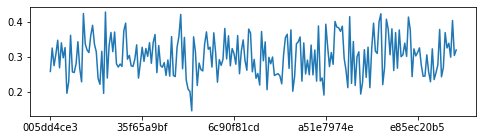

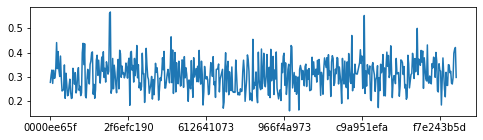

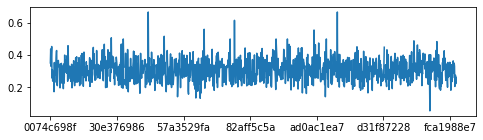

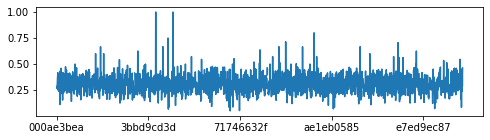

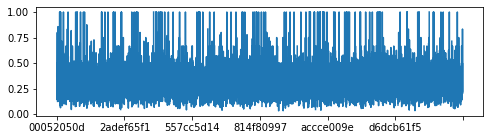

In [13]:
# Percentage Graph of nom group2
def feature_target_percent(df, feature, target, target_value):
    return df[df[target]==target_value][feature].value_counts().sort_index(axis = 0) / df[feature].value_counts().sort_index(axis = 0)

for i in range(5, 10):
    fig, ax = plt.subplots(1,1,figsize=(8, 2))
    P_nom = feature_target_percent(df_train, f'nom_{i}', 'target',1)
    P_nom.plot()
    
plt.show()

From distribution and percentage graph, as we expect it is pretty random. We will deal with these categorical feature later by some categorical encoding technics.

In [14]:
# Study ordinal features
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4','ord_5']
summary(df_train[ord_cols])

Dimensionality of the DataFrame: (300000, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,ord_0,int64,0,3,2,1,1,1.27
1,ord_1,object,0,5,Grandmaster,Grandmaster,Expert,2.05
2,ord_2,object,0,6,Cold,Hot,Lava Hot,2.36
3,ord_3,object,0,15,h,a,h,3.61
4,ord_4,object,0,26,D,A,R,4.51
5,ord_5,object,0,192,kr,bF,Jc,7.31


From the summary, we will seperate ordinal varibles into 2 groups too, based on the number of the unique values.

In [15]:
ord_group1 = ['ord_0', 'ord_1', 'ord_2']
ord_group2 = ['ord_3','ord_4','ord_5']

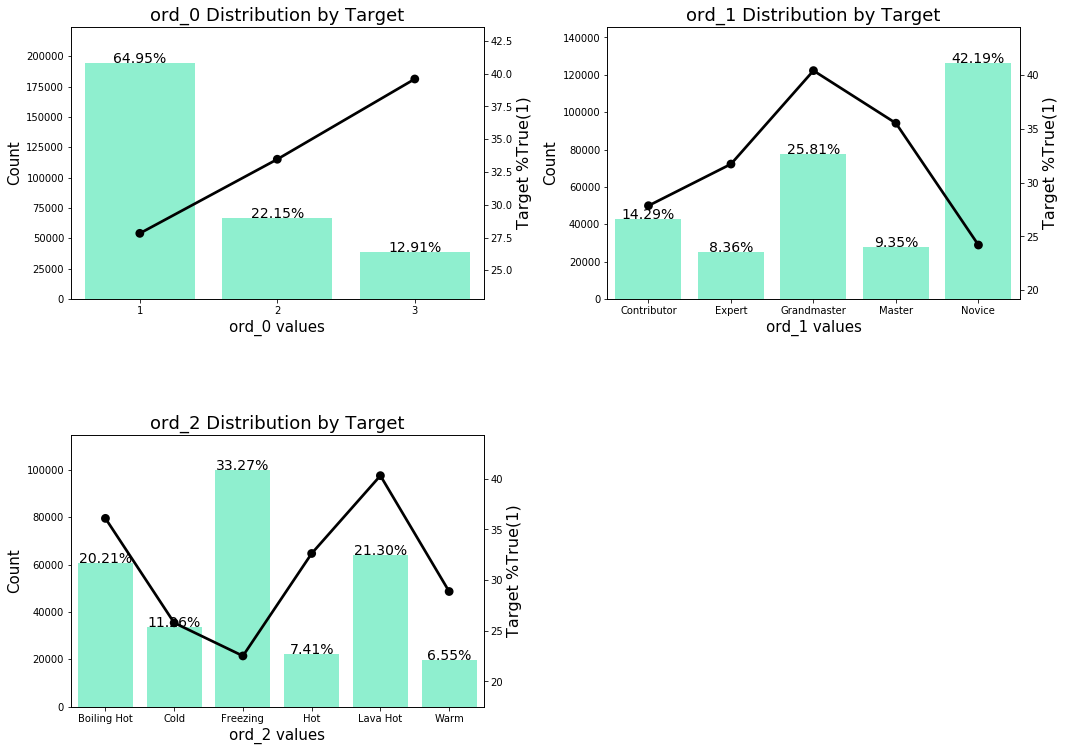

In [16]:
plot_cat_dist(df_train, ord_group1, vis_row=5, vis_col=2)

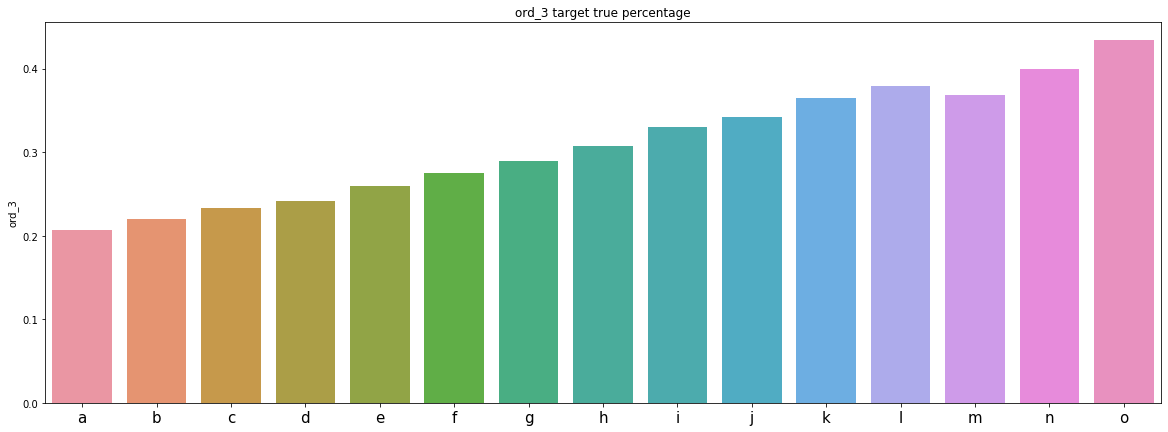

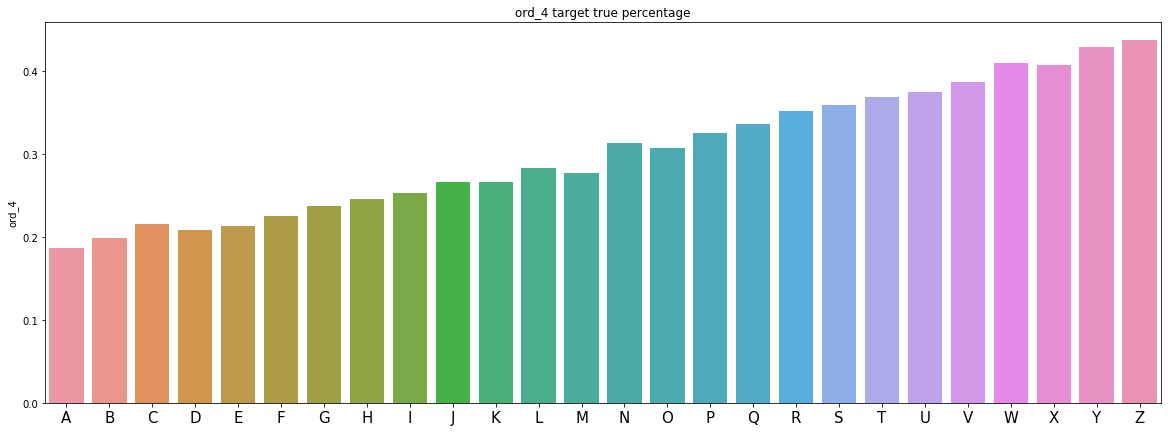

In [17]:
for i in range(3,5):
    P_ord = feature_target_percent(df_train, f'ord_{i}', 'target', 1)
    fig, ax = plt.subplots(1,1,figsize=(20,7))
    sns.barplot(P_ord.index, P_ord, ax=ax)
    plt.title(f'ord_{i} target true percentage')
    plt.setp(ax.get_xticklabels(), fontsize=15)
    
plt.show()

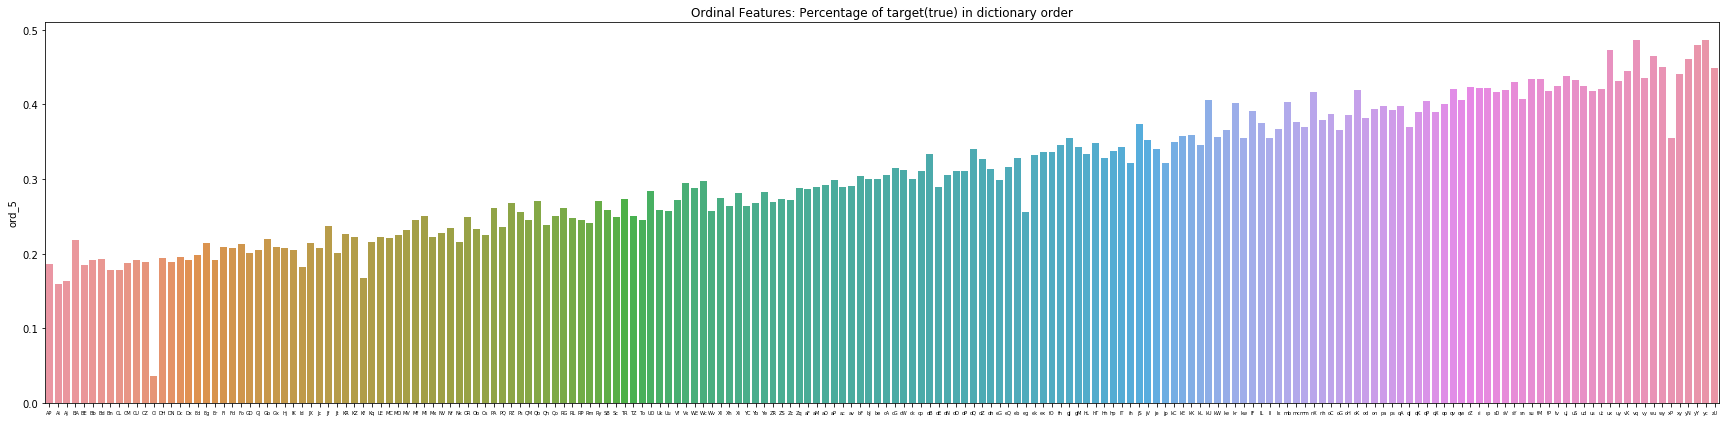

In [18]:
P_ord5 = feature_target_percent(df_train, f'ord_5', 'target', 1)
fig, ax = plt.subplots(1,1,figsize=(30,7))
sns.barplot(P_ord5.index, P_ord5, ax=ax)
plt.title('Ordinal Features: Percentage of target(true) in dictionary order')
plt.setp(ax.get_xticklabels(), fontsize=5)
    
plt.show()

ord_3 - ord_5 has a linear relationship with the value in dictionary order.

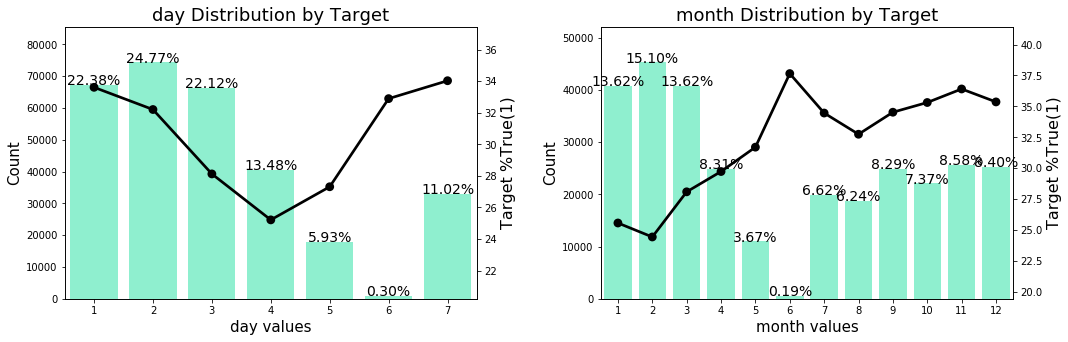

In [19]:
other_feature = ['day', 'month']
plot_cat_dist(df_train, other_feature, vis_row=5, vis_col=2)

A interesting finding:
The value '6' in both feature has lowest count but high percentage of target true.

Conclusion:
1. Binary feature (bin_3, bin_4) needs to tranform to numerical feature.
2. Ordinal features can use label encode (ordinal encode).
3. Nominal features can use One-Hot encode.